### Shrinkage Methods and Robust regression algorithms:

 We will continue using the Boston House data. Just a reminder, we wish to predict the house's median value based on some features.

 * Lab 3 covers the applying Linear regression.
 * In this lab, we will learn how to detect outliers on the data and apply and Shrinkage Methods & Robust regression algorithms
 * We will compare linear regression with Shrinkage Methods and Robust regression

In [ ]:
from random import random
from random import randint
from random import seed
from numpy import arange
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.datasets import make_regression
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot
import seaborn as sns
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Set up plotting environment
# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings

with warnings.catch_warnings():
  # ignore all caught warnings
	warnings.filterwarnings("ignore")




1. Loading the data:

In [ ]:
boston = datasets.load_boston()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

2. Load the data into a Pandas DataFrame df.

In [ ]:
# Load the data
df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
df['MEDV'] = boston['target']

3. check for outliers using histogram

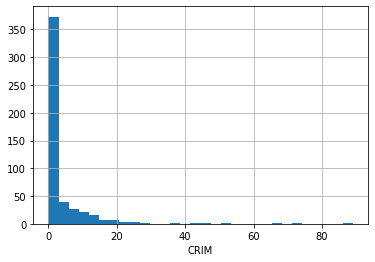

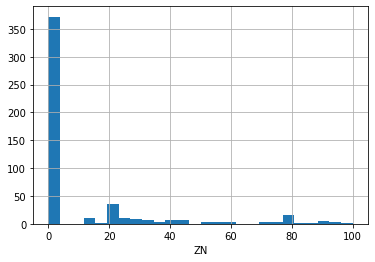

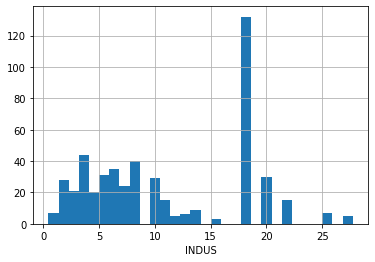

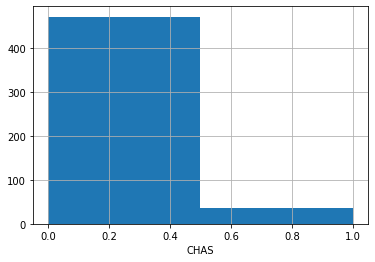

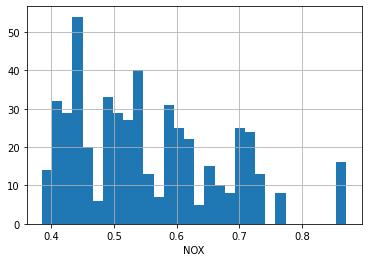

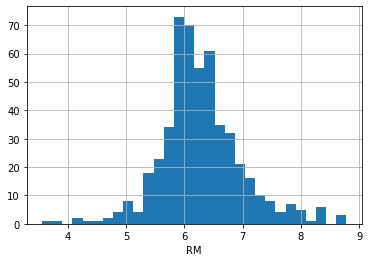

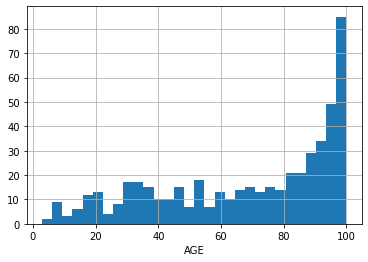

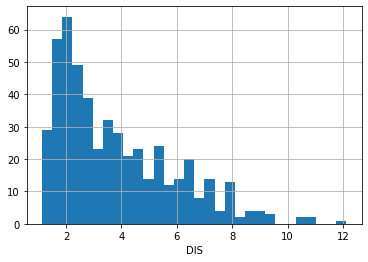

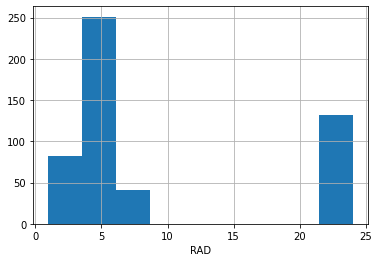

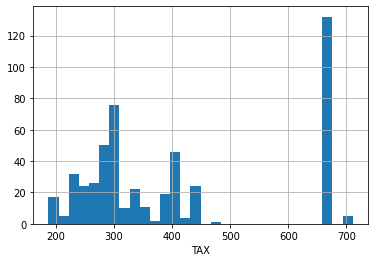

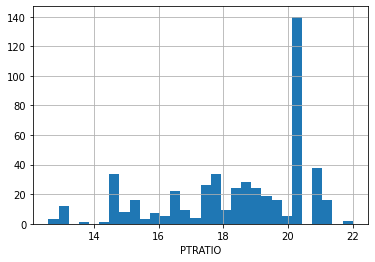

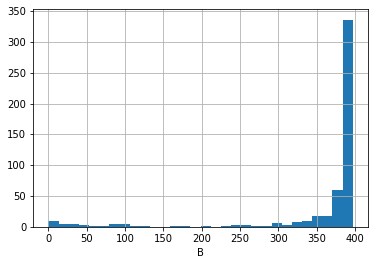

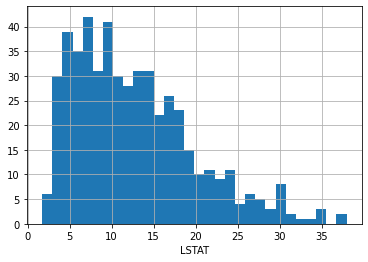

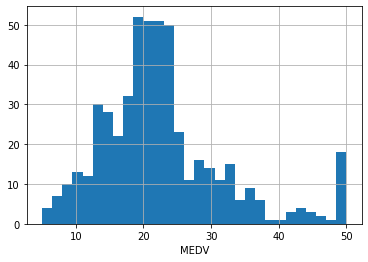

In [ ]:
# Print the distibutions
for f in df.columns:
    try:
        fig = plt.figure()
        num_bins = min((30, len(df[f].unique())))
        df[f].hist(bins=num_bins)
        plt.xlabel(f)
    except TypeError:
        print()
        print(df[f].value_counts())
        print('-'*30)
        plt.close()

Observations:

1- CRIM, ZN, INDUS, Tax, B, and Patrito look like they have outliers.

4. check for outliers using boxplot

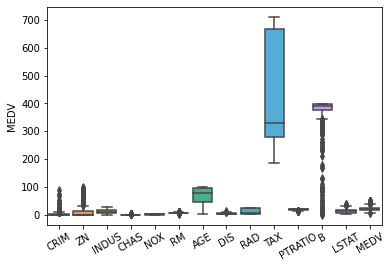

In [ ]:
data_melted = pd.melt(df)
fig = sns.boxplot(x = "variable" ,y = "value" , data = data_melted)
plt.ylabel( 'MEDV' )
plt.xlabel( '' )
fig.set_xticklabels(fig.get_xticklabels(),rotation =30 )
plt.show()

Observations:

1- CRIM, ZN, and B look like they have outliers.

### 5. Preparing the machine learning pipeline

1. divide the data into features (X) and target (y)

In [ ]:
X = df.loc[:, df.columns != 'MEDV']
y = df.loc[:,'MEDV']

2. Splitting the data into training and testing sets

We train the model with 70% of the samples and test with the remaining 30%.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
# print the sizes of our training and test set to verify if the splitting has occurred properly.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(354, 13)
(152, 13)
(354,)
(152,)


3. Scaling Data and linear regression declaration

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
lin_reg = LinearRegression()


4. Train Linear regression model and model evaluation

In [ ]:
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(StandardScaler(), LinearRegression())
scores_pipe_1 = cross_val_score(pipeline, X_train, y_train,cv=10)
print("Average 10-Fold CV R2 Score: {}".format((np.mean(scores_pipe_1)) ))
scores_pipe_2 = cross_val_score(pipeline, X_train, y_train,cv=10, scoring='neg_mean_squared_error') # this return the negated value of the MSE, make sure to multiply it by -1 to get the positive one
print("Average 10-Fold CV MSE Score: {}".format(-1*(np.mean(scores_pipe_2)) ))

Average 10-Fold CV R2 Score: 0.6875346951141132
Average 10-Fold CV MSE Score: 25.55066079166079


### 5. Shrinkage Methods

*1*. Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
pipe_ridg = make_pipeline(StandardScaler(), Ridge())
pipe_ridg.fit(X_train,y_train)
y_predt = pipe_ridg.predict(X_test)
print("Ridge train score: %0.6f" % pipe_ridg.score(X_train, y_train))
print("Ridge test score: %0.4f" % pipe_ridg.score(X_test,y_test))

Ridge train score: 0.743482
Ridge test score: 0.7108


Observations:

Numerically, we can see that we have a fair improvement on the estimation of the model (compared to the Linear Regression).

To get a better understanding of the penalty effect on the estimated values, let’s plot the shrinkage effect for different values of α’s, which shows us the shrinkage effect towards zero of the regression coefficients.

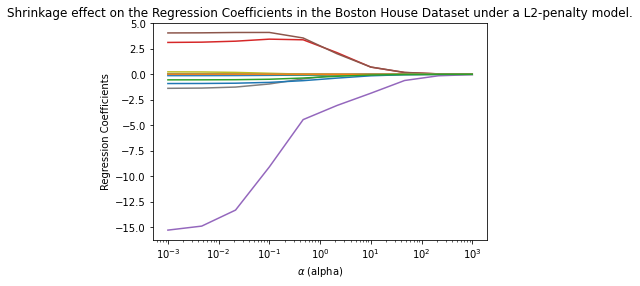

In [ ]:
with warnings.catch_warnings():
  # ignore all caught warnings
  warnings.filterwarnings("ignore")
  ridge = Ridge(normalize=True)
  alphas = np.logspace(-3,3,10)
  coef = []
  for a in alphas:
      ridge.set_params(alpha=a)
      ridge.fit(X_train,y_train)
      coef.append(ridge.coef_)
  ax = plt.gca()
  ax.plot(alphas, coef)
  ax.set_xscale('log')
  ax.set_xlim(ax.get_xlim())
  plt.xlabel('$\\alpha$ (alpha)')
  plt.ylabel('Regression Coefficients')
  plt.title("Shrinkage effect on the Regression Coefficients in the Boston House Dataset under a L2-penalty model.")
  plt.show()

Observations:

The coefficients are shrunk towards zero as α gets bigger

-> Choose the value of α that determines the best model:

we cross-validate the solution, that is we look for the value of α that maximizes the R2, which is by default the score metric in scikit-learn. This is done by performing the GridSearchCV, as follows:

In [ ]:
from sklearn.model_selection import GridSearchCV

with warnings.catch_warnings():
  # ignore all caught warnings
  warnings.filterwarnings("ignore")
  param_grid = {'alpha': np.logspace(-3,3,10)}
  grid = GridSearchCV(ridge, param_grid, scoring='neg_mean_absolute_error', cv=10, return_train_score=True)
  grid.fit(X_train,y_train)
  best_score = float(format(grid.best_score_, '.4f'))
  print('Best CV score: {:.4f}'.format(-1*(grid.best_score_)))
  print('Best parameter :',grid.best_params_)

Best CV score: 3.4684
Best parameter : {'alpha': 0.1}


-> validation_curve
Typically, one is interested not just in the estimated value, but also on the uncertanty over that estimate value; hence, we would like to see how much variability we have got on both the training and test sets of the cross-validation folds, and possibly showing the insights with a proper plot.

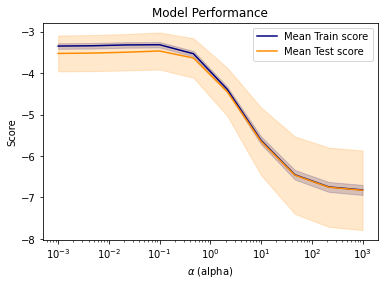

In [ ]:
train_scores_mean = grid.cv_results_["mean_train_score"]
train_scores_std = grid.cv_results_["std_train_score"]
test_scores_mean = grid.cv_results_["mean_test_score"]
test_scores_std = grid.cv_results_["std_test_score"]
plt.figure()
plt.title('Model Performance')
plt.xlabel('$\\alpha$ (alpha)')
plt.ylabel('Score')
plt.semilogx(alphas, train_scores_mean,
             label='Mean Train score',color='navy')
plt.gca().fill_between(alphas,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.2,
                    color='navy')
plt.semilogx(alphas, test_scores_mean,
             label='Mean Test score', color='darkorange')
plt.gca().fill_between(alphas,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.2,
                     color='darkorange')
plt.legend(loc='best')
plt.show()

Observations:

Mean Training vs Mean Test score under the Ridge Model for different value of α, with corresponding uncertanty. We see that the uncertanty drammatically reduce its effect after certain values of α, and that the train and test looks very similar, though the train always performs better than the test set, for those values.

*2. Lasso Regression*

A popular alternative to Ridge

-> fit a series of Lasso models for different values of α, and then we append to a new list all the estimated coefficients.

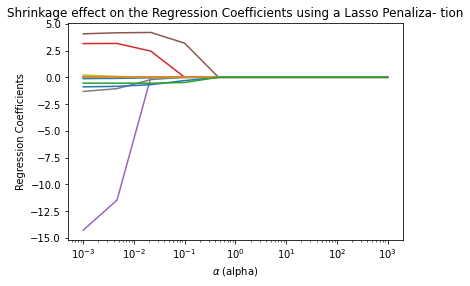

In [ ]:
from sklearn.linear_model import Lasso

with warnings.catch_warnings():
  # ignore all caught warnings
  warnings.filterwarnings("ignore")
  lasso = Lasso(max_iter=10000,normalize=True)
  coefs = list()
  for alpha in alphas:
      lasso.set_params(alpha=alpha)
      lasso.fit(X_train,y_train)
      coefs.append(lasso.coef_)
  ax = plt.gca()
  ax.plot(alphas, coefs)
  ax.set_xscale('log')
  ax.set_xlim(ax.get_xlim())
  plt.xlabel('$\\alpha$ (alpha)')
  plt.ylabel('Regression Coefficients')
  plt.title('Shrinkage effect on the Regression Coefficients using a Lasso Penaliza- tion')
  plt.show()


Lasso as feature selection:

Typically, one resorts to Lasso regression because it shrinks some of the coefficients to zero, which litterally translates into feature selection. We implent this method afain on the Boston House dataset, and see which features seem to be relevant for the prediction of the median house price.

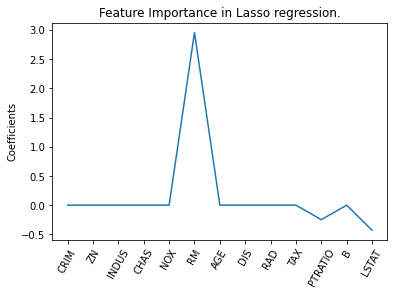

In [ ]:
names = df.drop('MEDV', axis=1).columns
with warnings.catch_warnings():
  # ignore all caught warnings
  warnings.filterwarnings("ignore")
  lasso = Lasso(alpha=0.1, normalize=True)
  lasso_coef = lasso.fit(X, y).coef_
  plt.plot(range(len(names)), lasso_coef)
  plt.xticks(range(len(names)), names, rotation=60)
  plt.ylabel('Coefficients')
  plt.title('Feature Importance in Lasso regression.')
  plt.show()

Lasso’s coefficients most important predictors have values different from zero, whereas the others are shrunk to zero.

This is very important procedure for any machine learning model, since it allows you to communicate a numerical result in terms of important factors that affect the dependent variable.

*3. Elastic Net*

A generalization of the lasso model is the Elastic Net

-> Tuning Elastic Net Hyperparameters:

How do we know that the default hyperparameters of alpha=1.0 and l1_ratio=0.5 are any good for our dataset?

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
with warnings.catch_warnings():
  warnings.filterwarnings("ignore")

  # ignore all caught warnings
  steps = [('scaler', StandardScaler()),('elasticnet', ElasticNet())]
  pipeline = Pipeline(steps)
  parameters = {'elasticnet__l1_ratio': np.linspace(0, 1, 30)}
  gm_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='neg_mean_absolute_error')
  results= gm_cv.fit(X_train, y_train)
  mse_test = gm_cv.score(X_test, y_test)
  print("Tuned ElasticNet Alpha: {}".format(gm_cv.best_params_))
  print("Tuned ElasticNet MSE Test score: {}".format(-1*mse_test))
  print("Tuned ElasticNet MSE Train score: {}".format(-1*results.best_score_))

Tuned ElasticNet Alpha: {'elasticnet__l1_ratio': 0.896551724137931}
Tuned ElasticNet MSE Test score: 3.6520222723341558
Tuned ElasticNet MSE Train score: 3.827853605291911


Observations:

The test score of MSE reduced from 25.55 to 3.65 using ElasticNet

#### 6. Train huber regression model and model evaluation on a dataset with outliers

In [ ]:
from sklearn.linear_model import HuberRegressor, RANSACRegressor

In [ ]:
# evaluate model
pipeline_huber = make_pipeline(StandardScaler(), HuberRegressor())
scores_huber = cross_val_score(pipeline_huber, X, y, scoring='neg_mean_absolute_error', cv=10)
#force scores to be positive
print("Average 10-Fold CV MSE Score for Huber regression: {}".format(absolute((np.mean(scores_huber)) )))

Average 10-Fold CV MSE Score for Huber regression: 3.7702235561971094


7. RANdom SAmple Consensus (RANSAC) :train the model and model evaluation

In [ ]:
# evaluate model
pipeline_ransac = make_pipeline(StandardScaler(),RANSACRegressor())
scores_RANSAC = cross_val_score(pipeline_ransac,X, y, scoring='neg_mean_absolute_error', cv=10)
#force scores to be positive
print("Average 10-Fold CV MSE Score for RANSAC regression: {}".format(absolute((np.mean(scores_RANSAC )) )))

Average 10-Fold CV MSE Score for RANSAC regression: 4.297995530018797


Observations:

1- huber regression minimize the MSE from 34.71 to 3.77.

2- Also, the RANSAC regression decreases error ~ 29 scores.